# Preprocessing Audio Samples

## 1. Dataset Overview

<p> From the Kaggle Freesound Audio Tagging dataset, I extracted samples from 10 differents classes. Each one of these classes are a instrument. The list of the classe is the following : </p>
<ul> 
    <li>Saxophone</li>
    <li>Violin_or_fiddle</li>
    <li>Hi-hat</li>
    <li>Snare_drum</li>
    <li>Acoustic_guitar</li> 
    <li>Double_bass</li>
    <li>Cello</li>
    <li>Bass_drum</li> 
    <li>Flute</li>
    <li>Clarinet</li>
</ul>

<p> For each one of theses classes, I picked 30 differents samples of different sizes. Therefore the training dataset has 300 samples. Here is a pie graph of the sample distribtuion for each classes based on sample length : </p>
<img src="class_distribution.png"></img>

## 2. Imports & Plot methods

In [10]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
df = pd.read_csv('/home/romain/TF Notebooks/Audio Classifier/instruments.csv')
df.set_index('fname', inplace=True)


def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


## 3. Prepocessing Computation

In [30]:
#Make the fast fourier transform with numpy
def fourier_calc(signal,rate):
    n = len(signal)
    freq = np.fft.rfftfreq(n, d=1/rate)
    magnitude = abs(np.fft.rfft(signal)/n)
    return (magnitude,freq)
#resample data by applying an enveloppe
#it will get rid of the data points where the microphone did not record anything
def threshold_envelope(signal,rate,threshold):
    #array containing indexes of data points to keep (true or false)
    mask = []
    #convert signal into a Pandas Series with absolute values
    y = pd.Series(signal).apply(np.abs)
    #look to all data points in a 0.1s window, compute the mean of it if there is at least 1 point
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        #if mean of all points is bigger than threshold
        if mean>threshold:
            #add 
            mask.append(True)
        else:
            mask.append(False)
    return mask

#dictionnaries used to store data
classes = list(np.unique(train.label))
signals_before_threshold = {}
#set of points representing the signal
signals = {}
#fourier transform (frequency + magnitude)
fft = {}
#signal with Mel filter bank applied
filterbank = {}
#signal with Mel cepstrum coefficient applied (low frequencies only)
mfccs = {}
#numbers of filters used for the Mel filter bank transformation
mel_filters = 26
#window size for FFT
#1 sec of sample = 44100 Hz
#20ms window size (standard window size) = 1103Hz
window_size = 1103

for c in classes:
    #get first filename for each classes
    filename = train[train.label == c].iloc[0,0]
    # sample rate is 44100 Hz for each sample
    signal,rate = librosa.load('/home/romain/TF Notebooks/Audio Classifier/wavfiles/'+filename, sr = 16000)
    signals_before_threshold[c] = signal
    #Threshold is 0.0005 cause librosa convert data points to very low numerical values
    mask = threshold_envelope(signal,rate,0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = fourier_calc(signal,rate)
    bank = logfbank(signal[:rate],rate,nfilt=mel_filters, nfft=window_size).T
    filterbank[c] = bank
    #Mel filter cepstrum coefficient computation
    #we take 1 sec of the sample at a rate of 44100 Hz
    #numcep is the number of filters we are discarding, here it is the 13 highest frenquencies spectrums
    mel = mfcc(signal[:rate], rate, numcep=13,nfilt=mel_filters, nfft=window_size).T
    mfccs[c] = mel


## 4. Processed samples overview

### 4.1 Preprocessed time serie samples

<p> On the X axis we have time (in s). On the y axis we have the amplitude, caracterized by the bit depth. We know tbhat our samples come from a microphone with 44.1kHz and 16 bit depth. That means it is able to pick up 44100 values per second, and each value consist of a 16 bit array. </p>

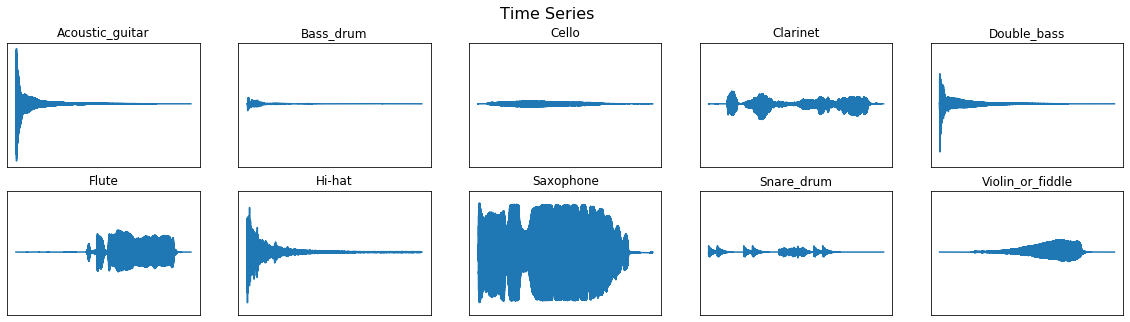

In [19]:
plot_signals(signals_before_threshold)
plt.show()

### 4.2 Time series with threshold enveloppe

<p> Here we are going to get rid of the parts where the microphone could not record enough data points. In order to do that we are going to use a rolling mean window. For each sample, we are going to look at all the points within a 0.10s window, and if there is at least one point in the window we will compute the mean of all points.Then we will compare that mean with a defined threshold. The threshold I used is 0.0005, I took this value because Librosa resample the wav file using small float values, and after experimenting I got the best results with that value. If the mean of all points is grater than the threshold, I keep the values, otherwise I discard it from the sample. </p>

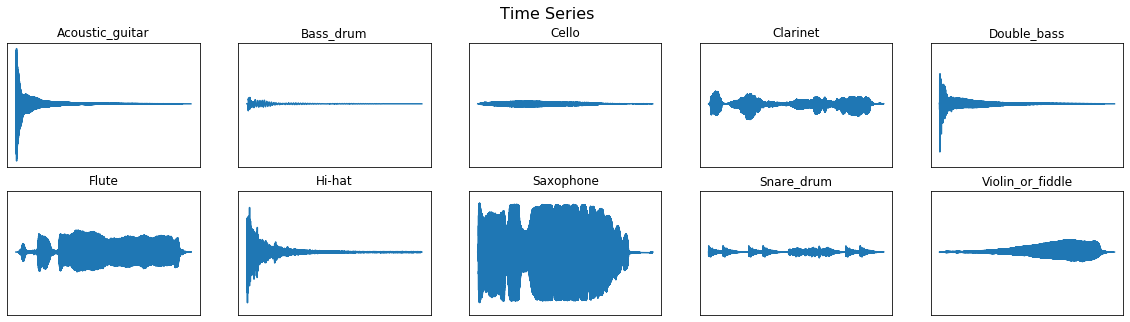

In [28]:
plot_signals(signals)
plt.show()

### 4.3 Short Time Fourier Transform

<p> First we are going to downsample our audio. The original sample rate is 44.1kHz, but all relevant data points can be represented within a 16kHz rate. I did that by specifying the rate in the librosa.load() function. I then used Numpy fft function to make the Fourier transform. </p>
<p> Applying a Fourier transform to the whole sample at once makes no sence because the frequencies keeps changing over time. Instead of that, we are going to use an overlapping window. We are going to look at all data points within a 25ms windows, make a fast Fourier transform, then move the window to 15ms to the right so it overlap 10ms, make a FFT and so on. We will store every FFT to represent the sample.</p>
<p>We now can use a spectrogram to represent the Short time Fourier transform. The frequency is in the x axis and the magnitude is in the y axis. </p>

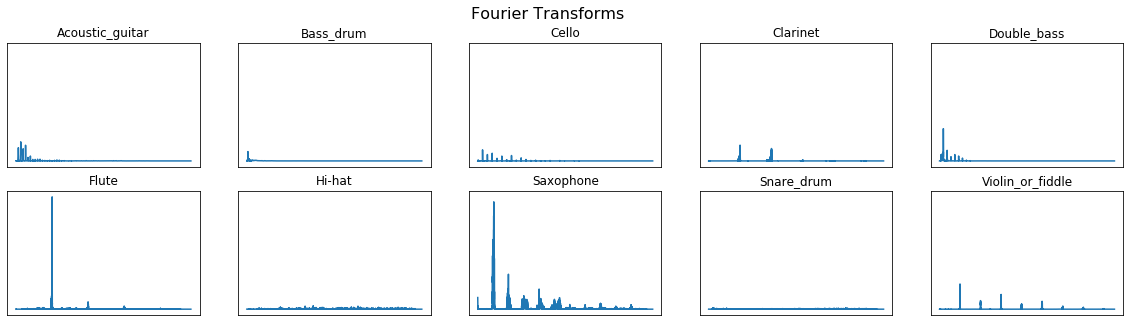

In [31]:
plot_fft(fft)
plt.show()

### 4.3 Mel Filter Bank

<p> The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear. </p>

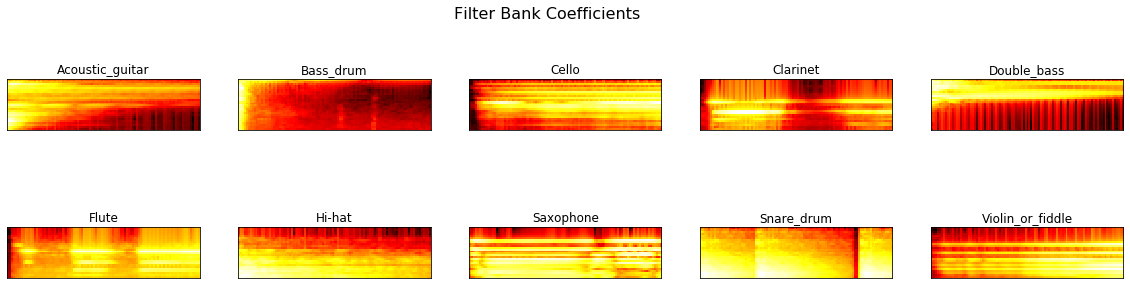

In [32]:
plot_fbank(filterbank)
plt.show()

### 4.4 Mel Cepstrum Coefficient

<p> Here we are going to discard the 13 highest frequencies filters to keep lower frequencies only, because change between samples are mostly recognizable in low frequencies </p>

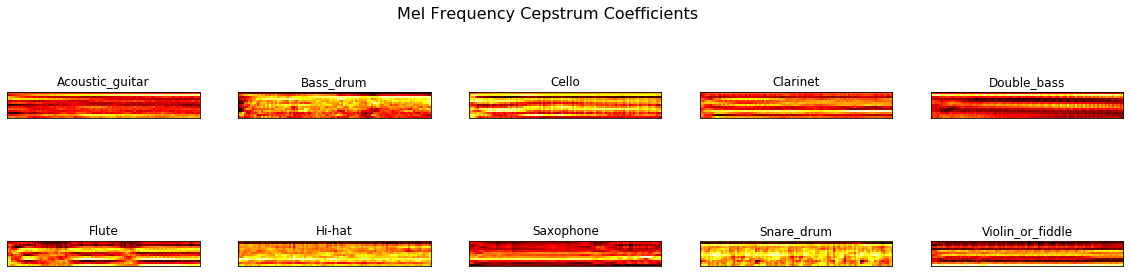

In [33]:
plot_mfccs(mfccs)
plt.show()

## 5. Saving the downsampled audio

<p> Here we will downsample the original audio file at a rate of 16000 Hz, then apply a threshold to it, then save the file in a new folder called "clean" </p>

In [35]:
for filename in df.index:
    signal,rate = librosa.load('/home/romain/TF Notebooks/Audio Classifier/wavfiles/'+filename, sr = 16000)
    mask = threshold_envelope(signal,rate,0.0005)
    wavfile.write(filename='/home/romain/TF Notebooks/Audio Classifier/clean/'+filename, rate=rate, data=signal[mask])